In [1]:

# -*- coding: utf-8 -*-
"""
Created on Wed Jan 19 18:24:48 2022

@author: ankit
"""
   
    
import os
os.chdir(r"C:\Users\ankit\OneDrive\Desktop\data_Imbalance_code_titanic")
import itertools 
from tqdm import tqdm
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import numpy as np
import random
RANDOM_SEED = 10
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
import warnings
warnings.filterwarnings("ignore")
import shap
from sklearn.metrics import roc_auc_score,classification_report,roc_curve,confusion_matrix
import pandas as pd

In [2]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Pastel1):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    print("------")
    print("Plot confusion matrix...")
    print("------")
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = np.round(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis],4)*100 
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
 
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="black" if cm[i, j] > thresh else "black")
    plt.rcParams.update({'font.size': 42})
    plt.rcParams['xtick.labelsize']=12
    plt.rcParams['ytick.labelsize']=12
#    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


def ABS_SHAP(df_shap,df):
    #import matplotlib as plt
    # Make a copy of the input data
    shap_v = pd.DataFrame(df_shap)
    feature_list = df.columns
    shap_v.columns = feature_list
    df_v = df.copy().reset_index().drop('index',axis=1)
    
    # Determine the correlation in order to plot with different colors
    corr_list = list()
    for i in feature_list:
        b = np.corrcoef(shap_v[i],df_v[i])[1][0]
        corr_list.append(b)
    corr_df = pd.concat([pd.Series(feature_list),pd.Series(corr_list)],axis=1).fillna(0)
    # Make a data frame. Column 1 is the feature, and Column 2 is the correlation coefficient
    corr_df.columns  = ['Variable','Corr']
    corr_df['Sign'] = np.where(corr_df['Corr']>0,'red','blue')
    
    # Plot it
    shap_abs = np.abs(shap_v)
    k=pd.DataFrame(shap_abs.mean()).reset_index()
    k.columns = ['Variable','SHAP_abs']
    k2 = k.merge(corr_df,left_on = 'Variable',right_on='Variable',how='inner')
    k2 = k2.sort_values(by='SHAP_abs',ascending = True)
    colorlist = k2['Sign']
    ax = k2.plot.barh(x='Variable',y='SHAP_abs',color = colorlist, figsize=(10,10),legend=False)
    ax.set_xlabel("SHAP Value (Red = Positive Impact on Positive Impact on Class 1)",size = 12)
    ax.tick_params(axis='y', which='major', labelsize=16)
    ax.tick_params(axis='x', which='major', labelsize=16)
    ax.set_ylabel('Features',size = 12)

In [3]:
data = pd.read_csv("train.csv")
data = data[['Survived', 'Pclass','Sex', 'Age', 'SibSp',
       'Parch', 'Fare', 'Embarked']]
data.Sex = data.Sex.map({'male':1,'female':2})
print("Null Values ----")
print(data.isnull().sum())

Null Values ----
Survived      0
Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
Embarked      2
dtype: int64


In [4]:
data.Embarked.fillna(data.Embarked.mode()[0], inplace=True)
data.Embarked = data.Embarked.map({'S':1,'C':2,'Q':3})
print("Null Values ----")
print(data.isnull().sum())

Null Values ----
Survived      0
Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
Embarked      0
dtype: int64


In [5]:
data.Age = data.Age.fillna(data.groupby('Sex')['Age'].transform('mean'))
print("Null Values ----")
print(data.isnull().sum())

Null Values ----
Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64


In [6]:
print("Class proportion")
print((data.Survived.value_counts()/data.shape[0])*100)
print("Class counts")
print((data.Survived.value_counts()))

Class proportion
0    61.616162
1    38.383838
Name: Survived, dtype: float64
Class counts
0    549
1    342
Name: Survived, dtype: int64


In [7]:
## Bootstrapping to get important Features

features = ['Pclass','Sex', 'Age', 'SibSp','Parch', 'Fare', 'Embarked']
target_col = ['Survived']
sample_size_minority = 300
sample_size_majority = 500
runs = 100

appended_feature_imp = []
for k in tqdm(range(runs)):
    temp = data.copy()
    temp_minority = temp.loc[temp.Survived==1,].sample(sample_size_minority)
    temp_majority = temp.loc[temp.Survived!=1,].sample(sample_size_majority)      
    data_sample = pd.concat([temp_minority,temp_majority],axis=0).sample(frac=1)
    data_sample.reset_index(drop=True, inplace=True)       
    labels_ = data_sample[target_col]   
    features_ =  data_sample[features]  
    features_train, features_test, labels_train, labels_test = train_test_split(features_, labels_,
                                                    stratify=labels_, test_size=0.2)
    model = xgb.XGBClassifier(random_state=RANDOM_SEED,objective='binary:logistic')    
    eval_set = [(features_train, labels_train), (features_test, labels_test)]
    model.fit(features_train, labels_train.values.ravel(), early_stopping_rounds=20, 
              eval_metric=["auc"], eval_set=eval_set, verbose=False)
    results=pd.DataFrame()
    results['columns']=features_.columns
    results['importances'] = model.feature_importances_
    appended_feature_imp.append(results)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:24<00:00,  4.13it/s]


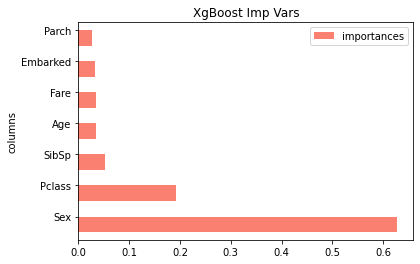

In [8]:
results = pd.concat(appended_feature_imp, axis=0).groupby(['columns'],as_index=False).mean()
results.sort_values(by='importances',ascending=False,inplace=True)
results.plot(colormap='Paired',x="columns", y="importances", kind="barh",fontsize = 10,position = 1,color="Salmon")
plt.title("XgBoost Imp Vars")

del appended_feature_imp,data_sample,eval_set,features,features_,features_test,features_train,k,labels_,labels_test,labels_train,temp,temp_majority,temp_minority

In [9]:
print("No of features to select")
top_features = 5
features = results.iloc[:top_features,0].tolist()
target_col = ['Survived']

labels_ = data[target_col]   
features_ =  data[features]  
features_train, features_test, labels_train, labels_test = train_test_split(features_, labels_,
                                                stratify=labels_, test_size=0.2,random_state=RANDOM_SEED)
model = xgb.XGBClassifier(random_state=RANDOM_SEED,objective='binary:logistic')    
eval_set = [(features_train, labels_train), (features_test, labels_test)]
model.fit(features_train, labels_train.values.ravel(), early_stopping_rounds=20, 
          eval_metric=["auc"], eval_set=eval_set, verbose=True)

No of features to select
[0]	validation_0-auc:0.88780	validation_1-auc:0.86614
[1]	validation_0-auc:0.89167	validation_1-auc:0.87852
[2]	validation_0-auc:0.90544	validation_1-auc:0.87978
[3]	validation_0-auc:0.91366	validation_1-auc:0.87484
[4]	validation_0-auc:0.91756	validation_1-auc:0.87740
[5]	validation_0-auc:0.92105	validation_1-auc:0.88057
[6]	validation_0-auc:0.92905	validation_1-auc:0.88393
[7]	validation_0-auc:0.93270	validation_1-auc:0.88590
[8]	validation_0-auc:0.94033	validation_1-auc:0.89157
[9]	validation_0-auc:0.94242	validation_1-auc:0.89223
[10]	validation_0-auc:0.94399	validation_1-auc:0.88992
[11]	validation_0-auc:0.94623	validation_1-auc:0.88083
[12]	validation_0-auc:0.94757	validation_1-auc:0.87872
[13]	validation_0-auc:0.94877	validation_1-auc:0.87833
[14]	validation_0-auc:0.95007	validation_1-auc:0.87806
[15]	validation_0-auc:0.95005	validation_1-auc:0.87648
[16]	validation_0-auc:0.95180	validation_1-auc:0.87846
[17]	validation_0-auc:0.95231	validation_1-auc:0.8

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=10,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [10]:
y_pred  = model.predict_proba(features_test)[:,1]
y_pred_df = pd.DataFrame({"actual":labels_test.Survived.ravel(),"predicted_prob":pd.Series(y_pred.ravel())})
print("Area Under ROC Curve is ::")
print(np.round(roc_auc_score(y_pred_df.actual, y_pred_df.predicted_prob)*100,2))    

Area Under ROC Curve is ::
89.22


------
Probability Distribution Plot
------


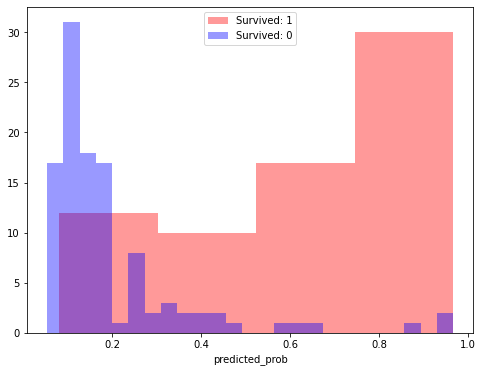

In [11]:
## Probability Distribution Plot
print("------")
print("Probability Distribution Plot")
print("------")
plt.figure(figsize = (8,6))
sns.distplot(y_pred_df[y_pred_df.actual==1]["predicted_prob"],kde=False,color="r",label='Survived: 1')
sns.distplot(y_pred_df[y_pred_df.actual==0]["predicted_prob"],kde=False,color="b",label='Survived: 0')
plt.legend()
plt.show()

In [12]:
## Finding Optimal Threshold
print("------")
print("Finding Optimal Threshold")
print("------")
fpr,tpr,thresholds = roc_curve(y_pred_df.actual,y_pred_df.predicted_prob)
tpr_fpr = pd.DataFrame({'tpr':tpr,'fpr':fpr,'thresholds':thresholds})
tpr_fpr['diff'] = tpr_fpr.tpr - tpr_fpr.fpr 
print(tpr_fpr.sort_values('diff',ascending=False).head(5))
print("-----")
print("Optimal Threshold")
threshold = tpr_fpr.loc[tpr_fpr['diff'].idxmax(), 'thresholds'];print(threshold)
print("-----")

------
Finding Optimal Threshold
------
         tpr       fpr  thresholds      diff
31  0.811594  0.090909    0.418086  0.720685
30  0.797101  0.081818    0.419795  0.715283
35  0.855072  0.163636    0.275203  0.691436
28  0.753623  0.072727    0.435596  0.680896
26  0.739130  0.063636    0.455568  0.675494
-----
Optimal Threshold
0.41808575
-----


In [13]:
# Confusion Matrix
print("------")
print("Confusion Matrix")
print("------")
y_pred_df['predicted'] = y_pred_df.predicted_prob.map(lambda x: 1 if x > threshold else 0)
cm = confusion_matrix(y_pred_df.actual,y_pred_df.predicted)
print(cm)

------
Confusion Matrix
------
[[101   9]
 [ 14  55]]


------
Plot confusion matrix...
------
Confusion matrix, without normalization


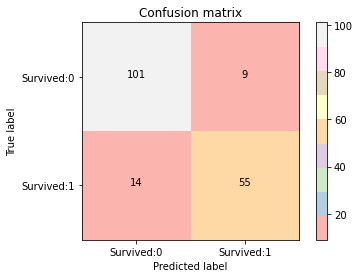

In [14]:
class_names = ["Survived:0","Survived:1"]
plt.figure()
plot_confusion_matrix(cm, classes=class_names, title='Confusion matrix')
plt.show()

In [15]:
# Classification Report
print("------")
print(" Classification Report")
print("------")

metric_df = pd.DataFrame(classification_report(y_pred_df.actual, y_pred_df.predicted, output_dict=True)).transpose()
print(metric_df)

------
 Classification Report
------
              precision    recall  f1-score     support
0              0.878261  0.918182  0.897778  110.000000
1              0.859375  0.797101  0.827068   69.000000
accuracy       0.871508  0.871508  0.871508    0.871508
macro avg      0.868818  0.857642  0.862423  179.000000
weighted avg   0.870981  0.871508  0.870521  179.000000


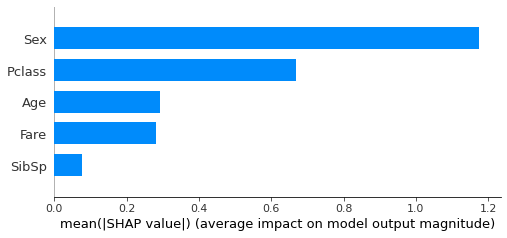

In [16]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(features_train)
shap.summary_plot(shap_values, features_train, plot_type="bar")

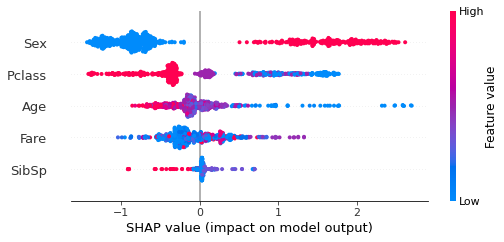

In [17]:
shap.summary_plot(shap_values,features_train)   

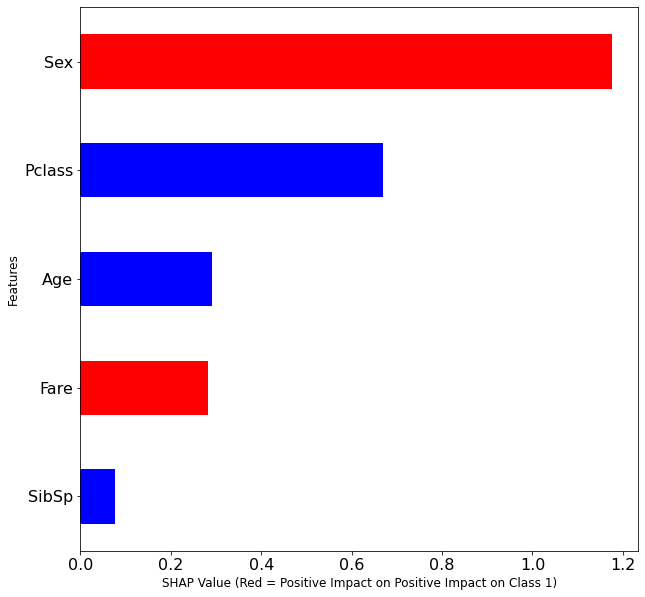

In [18]:
ABS_SHAP(shap_values, features_train)